## Run DQL with replay buffer with my gridworld## Run DQL with my gridworld

In [1]:
import random
from collections import deque
import copy

import numpy as np
import torch
from matplotlib import pylab as plt

from ggridworld.EnvWrapper import GridWorldEnv
from IPython.display import clear_output

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
size = 4

In [4]:
env = GridWorldEnv(size=size, holes=1, walls=1, use_random=True, rand_seed=12)
obs = env.reset()
env.render()

...#
....
....
.GO.



In [5]:
obs

array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 1., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 1., 0., 0.]],

       [[0., 0., 0., 1.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 1., 0.]]])

In [6]:
obs.shape

(4, 4, 4)

In [7]:
def get_env():
    env = GridWorldEnv(size=size, holes=1, walls=1, use_random=True)
    obs = env.reset()
    return obs, env

### Build the model

In [8]:
def get_model(size):
#     l_in = 64  # 4x4x4
    l_in = 4*size*size  # 216
    l2 = 150
    l3 = 100
    l_out = 4
    
    
    model = torch.nn.Sequential(
        torch.nn.Linear(l_in, l2),
        torch.nn.ReLU(),
        torch.nn.Linear(l2, l3),
        torch.nn.ReLU(),
        torch.nn.Linear(l3, l_out)
    )
    model.to(device)
    return model

In [9]:
learning_rate = 1e-3
model = get_model(size)
model_target = copy.deepcopy(model)
model_target.load_state_dict(model.state_dict())

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
def action_map(action):
    a_map = [0] * 4
    a_map[action] = 1
    return a_map

In [11]:
gamma = 0.9  # discount factor
epsilon = 0.3  # explore-exploit discounting
epochs = 5000
# epochs = 100
mem_size = 1000
batch_size = 200  # number of steps to learn each time
max_moves = 50
sync_freq = 500
move_num_global = 0

losses = []
replay = deque(maxlen=mem_size)

for epoch in range(epochs):
    obs, env = get_env()
    state_ = obs.reshape(1, 4*size*size) + np.random.rand(1, 4*size*size)/10.0
    prev_state = torch.from_numpy(state_).float().to(device)
    done = False
    move_num = 0
    while(not done):
        move_num_global += 1
        move_num += 1
        # Forward pass through model
        qval = model(prev_state)
        qval_ = qval.cpu().data.numpy()

        # Epsilon greedy
        if (random.random() < epsilon):
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)

        # Do the action and get new state
        action = action_map(action_)
        obs, reward, done, info = env.step(action)
        new_state_ = obs.reshape(1,4*size*size) + np.random.rand(1,4*size*size)/100.0
        new_state = torch.from_numpy(new_state_).float().to(device)

        experience = (prev_state, action_, reward, new_state, done)
        replay.append(experience)

        if len(replay) > batch_size:
            mini_batch = random.sample(replay, batch_size)
            state1_batch = torch.cat([s1 for (s1, a, r, s2, d) in mini_batch]).to(device)
            action_batch = torch.Tensor([a for (s1, a, r, s2, d) in mini_batch]).to(device)
            reward_batch = torch.Tensor([r for (s1, a, r, s2, d) in mini_batch]).to(device)
            state2_batch = torch.cat([s2 for (s1, a, r, s2, d) in mini_batch]).to(device)
            done_batch = torch.Tensor([d for (s1, a, r, s2, d) in mini_batch]).to(device)
            
            Q1 = model(state1_batch)
            with torch.no_grad():  # no backprop here so don't store graph
                Q2 = model_target(state2_batch)
            
            Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2, dim=1)[0])
            X = Q1.gather(dim=1, index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())

            # Output loss every 100 epochs
            if epoch % 100 == 0:
                print(epoch, loss.item())
                clear_output(wait=True)
                
            if move_num_global % sync_freq == 0:
                model_target.load_state_dict(model.state_dict())

            # Update the model with the loss
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
        
        prev_state = new_state

#     if epsilon > 0.1:
#         epsilon -= (1/epochs)
    
    if move_num > max_moves:
        done = True
        
losses = np.array(losses)        

4900 0.16983474791049957


In [12]:
def running_mean(x,N=50):
    c = x.shape[0] - N
    y = np.zeros(c)
    conv = np.ones(N)
    for i in range(c):
        y[i] = (x[i:i+N] @ conv)/N
    return y

Text(0, 0.5, 'Loss')

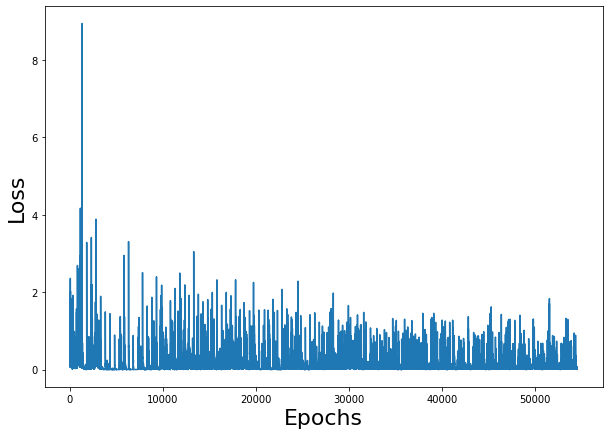

In [13]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [14]:
def test_model(model, display=True):
    move_count = 0
    game_won = False
    obs, env = get_env()
    state_ = obs.reshape(1, 4*size*size) + np.random.rand(1, 4*size*size)/10.0
    state = torch.from_numpy(state_).float()

    if display:
        print("Initial State:")
        env.render()
    done = False
    while(not done):
        qval = model(state.to(device))
        qval_ = qval.cpu().data.numpy()
        action_ = np.argmax(qval_)
        action = action_map(action_)
        if display:
            print('Move #: %s; Taking action: %s' % (move_count, action))
            
        obs, reward, done, info = env.step(action)
        state_ = obs.reshape(1,4*size*size) + np.random.rand(1,4*size*size)/10.0
        state = torch.from_numpy(state_).float()
        if display:
            print(env.render())

        if reward != -1:
            if reward > 0:
                if display:
                    print("Game won! Reward: %s" % (reward,))
#                     game_won =True
                return True
            else:
                if display:
                    print("Game LOST. Reward: %s" % (reward,))
                return False
        move_count += 1
        if (move_count > 50):
            if display:
                print("Game lost; too many moves.")
            return False
            break
    
    return game_won

In [15]:
max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model, display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))

Games played: 1000, # of wins: 882
Win percentage: 88.2%


In [16]:
test_model(model)

Initial State:
....
P...
..G.
.#O.

Move #: 0; Taking action: [0, 0, 0, 1]
....
.P..
..G.
.#O.

None
Move #: 1; Taking action: [0, 0, 0, 1]
....
..P.
..G.
.#O.

None
Move #: 2; Taking action: [0, 1, 0, 0]
....
....
..G.
.#O.

None
Game won! Reward: 10


True